# Wave Machine Learning Engineer Challenge

## Classification

This notebook contains a detailed solution to the following task:

*Train a learning model that assigns each expense transaction to one of the set of predefined categories and evaluate it against the validation data provided. The set of categories are those found in the "category" column in the training data. Report on accuracy and at least one other performance metric.*

Outline of methodology:

- Load and explore the data.
- Employ preprocessing tools such as dummy encoding and feature scaling.
- Outline evaluation metrics to be used for analyzing training results
- Train using boosting algorithms on the data (and its subsets).

## 0. Libraries

In [1]:
import warnings

import numpy as np # linear algebra
import pandas as pd # data analysis

# training algorithms
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# preprocessing and model evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, zero_one_loss, f1_score 
from sklearn_evaluation.plot import confusion_matrix
from sklearn.model_selection import GridSearchCV, LeaveOneOut

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data

We work with two types of datasets: an employee data (which includes information about the employees themselves), and an expenses data (training/validation - which includes details about the employees's expenses).

In [2]:
# import the csv files using pandas
training_data = pd.read_csv('training_data_example.csv')
validation_data = pd.read_csv('validation_data_example.csv')
employee_data = pd.read_csv('employee.csv')

Let us take a closer look at our data.

In [3]:
print('Training Data' '\n') 
print(training_data.info())
training_data.head()

Training Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
date                   24 non-null object
category               24 non-null object
employee id            24 non-null int64
expense description    24 non-null object
pre-tax amount         24 non-null float64
tax name               24 non-null object
tax amount             24 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.4+ KB
None


,date,category,employee id,expense description,pre-tax amount,tax name,tax amount
0,11/1/2016,Travel,7,Taxi ride,40.0,NY Sales tax,3.55
1,11/15/2016,Meals and Entertainment,1,Team lunch,235.0,CA Sales tax,30.55
2,11/30/2016,Computer - Hardware,3,HP Laptop Computer,999.0,CA Sales tax,129.87
3,11/14/2016,Computer - Software,3,Microsoft Office,899.0,CA Sales tax,116.87
4,11/6/2016,Computer - Software,4,Dropbox Subscription,50.0,CA Sales tax,6.50


In [4]:
print('Validation Data' '\n') 
print(validation_data.info())
validation_data.head()

Validation Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
date                   12 non-null object
category               12 non-null object
employee id            12 non-null int64
expense description    12 non-null object
pre-tax amount         12 non-null float64
tax name               12 non-null object
tax amount             12 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 752.0+ bytes
None


,date,category,employee id,expense description,pre-tax amount,tax name,tax amount
0,11/10/2016,Travel,7,Taxi ride,30.0,NY Sales tax,2.66
1,11/12/2016,Meals and Entertainment,1,Dinner with Family,235.0,CA Sales tax,30.55
2,9/2/2016,Computer - Hardware,4,Macbook Air Computer,4000.0,CA Sales tax,520.00
3,9/2/2016,Office Supplies,4,Paper,20.0,CA Sales tax,2.60
4,9/2/2016,Office Supplies,4,Pens,20.0,CA Sales tax,2.60


In [5]:
print('Employee Data' '\n') 
print(employee_data.info())
employee_data.head()

Employee Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
employee id         7 non-null int64
employee name       7 non-null object
employee address    7 non-null object
role                7 non-null object
dtypes: int64(1), object(3)
memory usage: 304.0+ bytes
None


,employee id,employee name,employee address,role
0,1,Steve Jobs,"235 Carlaw Ave, Toronto, ON, Canada",CEO
1,2,Jonathan Ive,"1 Yonge St, Toronto, ON, Canada",Engineer
2,3,Tim Cook,"1 Infinite Loop, Toronto, ON, Canada",IT and Admin
3,4,Larry Page,"1600 Amphitheatre Parkway, Hamilton, ON, Canada",Sales
4,5,Jonathan Ive,"1 Yonge St, Toronto, ON, Canada",Engineer


It's good to know that we have no null values. Let us join the employee data with each of the expense datasets, using *employee id* as the common column.

In [6]:
TD = pd.merge(training_data, employee_data, on='employee id')
VD = pd.merge(validation_data, employee_data, on='employee id')

## 2. Preprocessing

One thing to note is that an employee's id and name both give the same information, so we can drop *employee name*. Lets us also drop *employee address*, as only one employee lives in New York, and that information is captured in the *tax name* column. However the information in *tax name* is further captured by *tax amount*, since NY and CA sales tax ratios are well reflected:

In [7]:
pd.concat([TD['tax name'], (TD['pre-tax amount']/TD['tax amount'])], axis=1).head()

,tax name,0
0,NY Sales tax,11.267606
1,NY Sales tax,11.267606
2,NY Sales tax,11.267685
3,CA Sales tax,7.692308
4,CA Sales tax,7.692308


So we can also drop *tax name*.

Note: I am assuming that the above ratio applies to categories that may not be in this sample dataset. I.e. if a new tax is present, it will also be reflected in the ratio of pre-tax and tax amounts.

In [8]:
TD = TD.drop(['employee address', 'employee name', 'tax name'], axis=1)
VD = VD.drop(['employee address', 'employee name', 'tax name'], axis=1)

Next, we have a column containing dates. This could potentially be important in determining business vs personal expenses (and even the category of expenses), because personal expenses can ramp up during holidays. To simplify things, let us only extract the month from each date.

In [9]:
# convert the date column to a datetime format, then extract only the month
TD['month'] = pd.to_datetime(TD.date).dt.month
VD['month'] = pd.to_datetime(VD.date).dt.month

# drop date as a column
TD = TD.drop(['date'], axis=1)
VD = VD.drop(['date'], axis=1)

Also note that columns such as *role* iare categorical. Let us encode them as dummy variables.

In [10]:
# dummy encoding
TD = pd.concat([TD, pd.get_dummies(TD['role']), 
                pd.get_dummies(TD['employee id']),
               pd.get_dummies(TD['month'])], axis=1)
VD = pd.concat([VD, pd.get_dummies(VD['role']), 
                pd.get_dummies(VD['employee id']),
               pd.get_dummies(VD['month'])], axis=1)

# drop original columns
TD = TD.drop(['role','employee id','month'], axis=1)
VD = VD.drop(['role','employee id','month'], axis=1)

We also scale the tax features into the interval [0,1] to ensure no geometric bias towards features with large real-values. 

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
TD[['pre-tax amount','tax amount']] = scaler.fit_transform(TD[['pre-tax amount','tax amount']])
VD[['pre-tax amount','tax amount']] = scaler.fit_transform(VD[['pre-tax amount','tax amount']])

Now, we have a descriptive column: *expense description*. We can use *TfidfVectorizer* to convert this to a matrix of TF-IDF features. tf–idf (term frequency–inverse document frequency) is a statistic that is intended to reflect how important a word is to a document in a collection. It increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the collection, which helps to adjust for the fact that some words appear more frequently in general. 

In [12]:
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(TD['expense description'])
training_vecs = vectorizer.transform(TD['expense description']).toarray()
validation_vecs = vectorizer.transform(VD['expense description']).toarray()

We define our feaures and labels.

In [13]:
# features for the MLP
training_cols = np.array(TD.drop(['category', 'expense description'], axis=1))
validation_cols = np.array(VD.drop(['category', 'expense description'], axis=1))
X_train = np.c_[training_cols, training_vecs]
X_valid = np.c_[validation_cols, validation_vecs]
print('Training features shape:', X_train.shape)
print('Validation features shape:', X_valid.shape)

# labels
y_train = TD['category']
y_valid = VD['category']

Training features shape: (24, 43)
Validation features shape: (12, 43)


Before proceeding, let's look at the distribution of labels.

(-1.1362697079264235,
 1.1017271289488773,
 -1.101144524405598,
 1.1240348317468205)

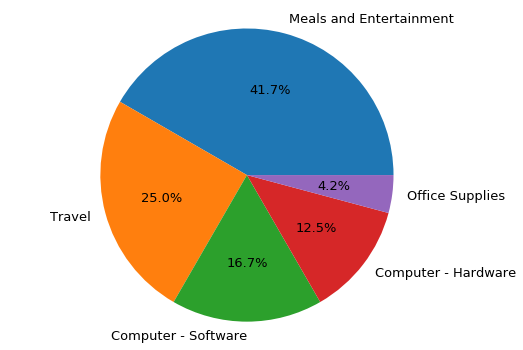

In [14]:
y_train.value_counts().plot(kind='pie', 
                                  figsize=(8,6), 
                                  fontsize=13, 
                                  autopct='%1.1f%%', 
                                  wedgeprops={'linewidth': 5}
                                  )
plt.axis('off')
plt.axis('equal')

Clearly the dataset is imbalanced - with some labels having a larger number of occurances than others. This is a good indication that something like accuracy will not be a good evaluation metric. Instead we employ tools such as confusion matrix and f1 score. These will be observed after training is complete. For now we encode our labels.

In [15]:
# first encode the string labels as ints
le = LabelEncoder()
le.fit(y_train)
names = set(y_valid) # label names to be used later
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_valid.shape)

Training labels shape: (24,)
Validation labels shape: (12,)


## 4. Training

We start by using a random forest estimator. This is an ensemble learning technique that works by constructing several decision trees at training time and outputting - for classification problems - the class that is the mode of the classes of the individual trees. Following are some of the important parameters.

- *n_estimators*: The number of trees in the forest.
- *max_features*: The number of features to consider when looking for the best split. For 'sqrt', $\text{max_features} = \sqrt{\text{number of features}}$.

To get a good sense of how the main feaure-subsets contribute to the classification, we will train (and validate) using three subsets. Recall:

- *training_vecs* is the set of TF-IDF features generated from the *expense description* column.
- *training_cols* is the set of categorical and numerical features that were retained after the preprocessing step.
- *X_train* contains the above two.

Likewise for the validation subsets.

In [16]:
seed = 10 # set seed
classifier = RandomForestClassifier(n_jobs=-1,
                                    max_features='sqrt',
                                    bootstrap=True, 
                                    oob_score=True, 
                                    random_state=seed)
# to find the best hyperparameters
param_grid = {'n_estimators': [25,50,100,200,300]}

# for the sake of using a small sample dataset, let's use LeaveOneOut CV. 
# if however a larger dataset is used, resort to a standard CV.
if X_train.shape[0] < X_train.shape[1]*5:
    # five times the number of features
    cv = LeaveOneOut()
else:
    cv = 5

In [17]:
# using TF-IDF features
grid_search_tfdif = GridSearchCV(estimator=classifier, 
                           param_grid=param_grid, 
                           cv=cv, 
                           verbose=0)
grid_search_tfdif.fit(training_vecs, y_train)
print('Best parameters using training_vecs data', grid_search_tfdif.best_params_)

Best parameters using training_vecs data {'n_estimators': 100}


In [18]:
# using categorical and numerical features
grid_search_cn = GridSearchCV(estimator=classifier, 
                           param_grid=param_grid, 
                           cv=cv, 
                           verbose=0)
grid_search_cn.fit(training_cols, y_train)
print('Best parameters using training_cols data', grid_search_cn.best_params_)

Best parameters using training_cols data {'n_estimators': 25}


In [19]:
# using all features
grid_search_all = GridSearchCV(estimator=classifier, 
                           param_grid=param_grid, 
                           cv=cv, 
                           verbose=0)
grid_search_all.fit(X_train, y_train)
print('Best parameters using X_train data', grid_search_all.best_params_)

Best parameters using X_train data {'n_estimators': 200}


In [20]:
print('Score using training_vecs data:', grid_search_tfdif.best_estimator_.score(validation_vecs, y_valid))
print('Score using training_cols data:', grid_search_cn.best_estimator_.score(validation_cols, y_valid))
print('Score using X_train data:', grid_search_all.best_estimator_.score(X_valid, y_valid))

Score using training_vecs data: 0.9166666666666666
Score using training_cols data: 0.3333333333333333
Score using X_train data: 1.0


It makes sense that using a combination of text, categorical and numemerical features allows for a better classification score (mean accuracy). The *expense description* column alone yields a score of ~92% (on the sample data), while the remaining features result in a score that is far lower. However this could be a result of the small sample datasets at our disposal.

Let us next explore XGBoostClassifier, which implements gradient boosted decision trees for classification. There are many hyperparameters that can be tuned (including regularization strength and tree depth). Following are some of the important parameters.

- *max_depth*: Maximum tree depth.
- *learning_rate*: Boosting learning rate.
- *reg_alpha*: L1 regularization for weights.
- *reg_lambda*: L2 regularization for weights.
- *objective*: Learning objective; 'multi-softmax' performs multiclass classification using the softmax function.

Now, since we know that using a combination of all features (post-processing) results in optimal results, let us do the same for xgboost. 

In [21]:
# suppressing some deprecated warnings
warnings.filterwarnings("ignore")

xgb = XGBClassifier(objective='multi:softmax', 
                    num_class=len(set(y_train)),
                    random_state=seed)
param_grid_xgb = {'max_depth': [3,5,7],
                  'learning_rate': [0.001,0.01,0.1],
                  'subsample':[0.5,1],
                  'colsample_bytree':[0.5,1],
                  'reg_alpha':[0,1,2]}
grid_search_xgb = GridSearchCV(estimator=xgb,
                               param_grid=param_grid_xgb, 
                               cv=cv,
                               verbose=0)
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(), error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_class=5, objective='multi:softmax',
       random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'colsample_bytree': [0.5, 1], 'learning_rate': [0.001, 0.01, 0.1], 'reg_alpha': [0, 1, 2], 'subsample': [0.5, 1], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
print('Best parameters for xgboost', grid_search_xgb.best_params_)
print('Score for xgboost:', grid_search_xgb.best_estimator_.score(X_valid, y_valid))

Best parameters for xgboost {'reg_alpha': 1, 'subsample': 1, 'learning_rate': 0.01, 'max_depth': 3, 'colsample_bytree': 1}
Score for xgboost: 1.0


## 5. Evaluation

We use the following metrics to evaluate our models:

* The *f1 score* can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. The formula for the F1 score is 

$$ \text{F1} = 2 \frac{(precision * recall)}{(precision + recall)}. $$

* A *confusion matrix* $C$ is such that $C_{i, j}$ is equal to the number of observations known to be in group i but predicted to be in group j.

Note that *classification_report* calculates the f1 score for each label and finds their average (weighted by the number of true instances for each label). This accounts for label imbalance.

                         precision    recall  f1-score   support

        Office Supplies       1.00      1.00      1.00         1
Meals and Entertainment       1.00      1.00      1.00         7
                 Travel       1.00      1.00      1.00         2
    Computer - Hardware       1.00      1.00      1.00         2

            avg / total       1.00      1.00      1.00        12

Number of misclassifications: 0 | Ratio of misclassifications: 0.0


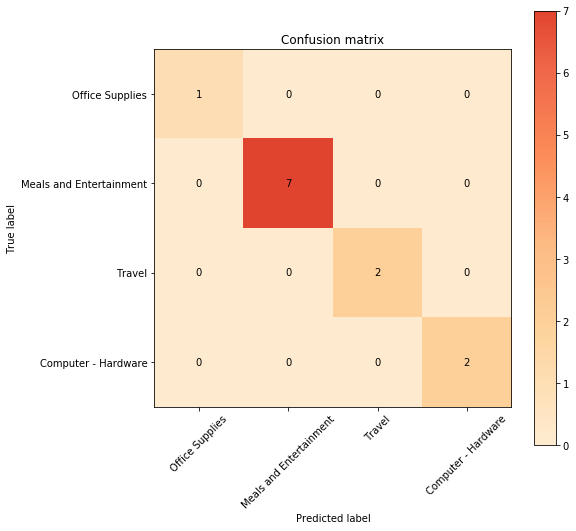

In [23]:
# random forest classifier evaluation

predictions_rfc = grid_search_all.best_estimator_.predict(X_valid) # predicted labels
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation=45)
confusion_matrix(y_valid, predictions_rfc, names).grid(False)
print(classification_report(y_valid, predictions_rfc, None, names))
print('Number of misclassifications:', zero_one_loss(y_valid, predictions_rfc, normalize=False),
      '| Ratio of misclassifications:', zero_one_loss(y_valid, predictions_rfc, normalize=True))

                         precision    recall  f1-score   support

        Office Supplies       1.00      1.00      1.00         1
Meals and Entertainment       1.00      1.00      1.00         7
                 Travel       1.00      1.00      1.00         2
    Computer - Hardware       1.00      1.00      1.00         2

            avg / total       1.00      1.00      1.00        12

Number of misclassifications: 0 | Ratio of misclassifications: 0.0


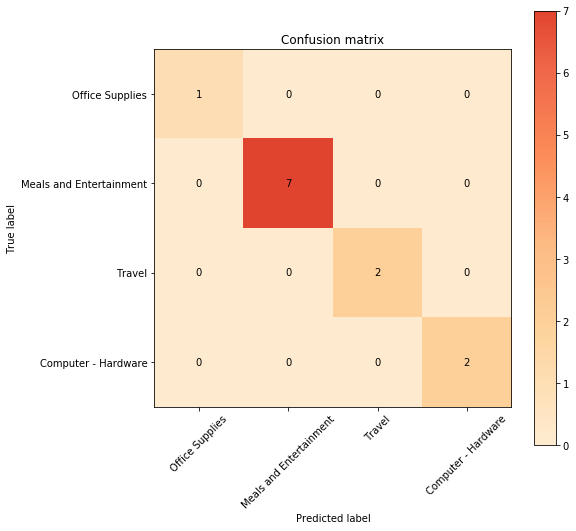

In [24]:
predictions_xgb = grid_search_xgb.best_estimator_.predict(X_valid) # predicted labels
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation=45)
confusion_matrix(y_valid, predictions_xgb, names).grid(False)
print(classification_report(y_valid, predictions_xgb, None, names))
print('Number of misclassifications:', zero_one_loss(y_valid, predictions_xgb, normalize=False),
      '| Ratio of misclassifications:', zero_one_loss(y_valid, predictions_xgb, normalize=True))

Lastly, let's include the f1-score and mean accuracy for both classifiers on training and validation sets.

In [25]:
print('Random Forest')
print('Classification accuracy (training):', grid_search_all.best_estimator_.score(X_train, y_train))
print('Classification accuracy (validation):', grid_search_all.best_estimator_.score(X_valid, y_valid))
print('F1-score (training):', f1_score(y_train, grid_search_all.best_estimator_.predict(X_train), average='weighted'))
print('F1-score (validation):', f1_score(y_valid, predictions_rfc, average='weighted'))
print('')
print('XGBoost')
print('Classification accuracy (training):', grid_search_xgb.best_estimator_.score(X_train, y_train))
print('Classification accuracy (validation):', grid_search_xgb.best_estimator_.score(X_valid, y_valid))
print('F1-score (training):', f1_score(y_train, grid_search_xgb.best_estimator_.predict(X_train), average='weighted'))
print('F1-score (validation):', f1_score(y_valid, predictions_xgb, average='weighted'))

Random Forest
Classification accuracy (training): 1.0
Classification accuracy (validation): 1.0
F1-score (training): 1.0
F1-score (validation): 1.0

XGBoost
Classification accuracy (training): 0.9166666666666666
Classification accuracy (validation): 1.0
F1-score (training): 0.9134920634920635
F1-score (validation): 1.0


Both classifiers performed seemingly well on the toy validation sets, so there isn't much to say in terms of comparing the two models (at least not on this dataset). However, xgboost is known to utilize a plethora of hyperparameters that can be fine-tuned to achieve better performance than random forests. In conclusion, here are some pros and cons of each model used:

**Random Forest**

Pros:
- Reduced variance in comparison to regular decision trees.
- Can easily handle categorical features.
- Trees can be decorrelated, which automatically helps with multi-collinearity of features.

Cons:
- Not easy to visually interpret.

**XGBoost**

Pros:
- Very flexible with parameters such as learning rate and the ability to use custom loss functions.
- Can easily handle categorical features.

Cons:
- I am very new to xgboost, so I honestly can't think of any cons aside from the confusion that may arise from dealing with so many hyperparameters.